In [2]:
!pip install python-docx


In [3]:
import os
import fitz  # PyMuPDF for PDF text extraction
import re
import docx
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Bidirectional, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from wordcloud import WordCloud

In [4]:
def extract_text_from_docx(docx_path):
    doc = docx.Document(docx_path)
    return " ".join([para.text for para in doc.paragraphs])

def extract_text_from_pdf(pdf_path):
    text = ""
    with fitz.open(pdf_path) as doc:
        for page in doc:
            text += page.get_text("text") + "\n"
    return text

resume_folder = r"C:\Users\HP-PC\Desktop\Python data analytics\resume data set\Resumes"
resume_files = [os.path.join(resume_folder, file) for file in os.listdir(resume_folder) if file.endswith((".pdf", ".docx"))]
resume_texts = {os.path.basename(file): extract_text_from_pdf(file) if file.endswith(".pdf") else extract_text_from_docx(file) for file in resume_files}


In [5]:
def clean_text(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and new lines
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'[^a-zA-Z0-9@. ]+', '', text)  # Remove special characters
    return text.lower()

cleaned_resumes = {file: clean_text(text) for file, text in resume_texts.items()}

In [6]:
def extract_email(text):
    match = re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', text)
    return match.group(0) if match else None

def extract_phone(text):
    match = re.search(r'\b\d{10}\b', text)
    return match.group(0) if match else None

resume_info = []
for file, text in cleaned_resumes.items():
    resume_info.append({
        "File": file,
        "Email": extract_email(text),
        "Phone": extract_phone(text),
        "Word Count": len(text.split())
    })
resume_df = pd.DataFrame(resume_info)

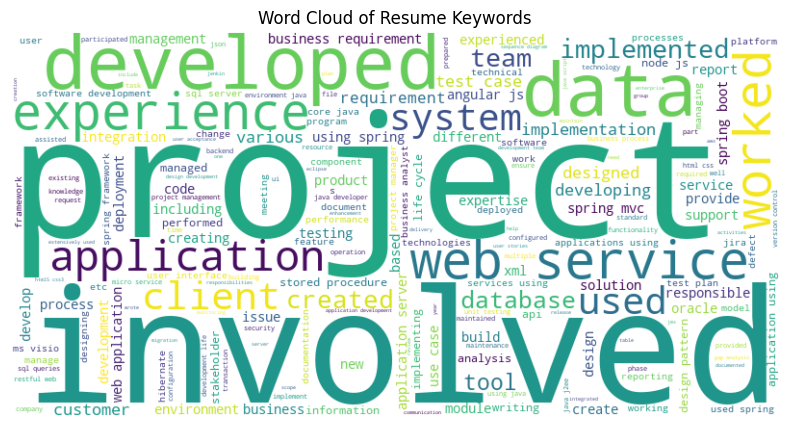

In [7]:
all_text = " ".join(cleaned_resumes.values())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Resume Keywords")
plt.show()


In [8]:
jobRoles = { 'Frontend Engineer': ['frontend', 'HTML', 'CSS', 'React', 'JavaScript', 'UI', 'UX'],
             'Backend Engineer': ['backend', 'Java', 'Python', 'SQL', 'API', 'Flask', 'Django'],
             'Fullstack Developer': ['fullstack', 'React', 'Node.js', 'JavaScript', 'MongoDB'],
             'Data Scientist': ['Python', 'SQL', 'Machine Learning', 'AI', 'NLP'],
             'AI Engineer': ['AI', 'Deep Learning', 'TensorFlow', 'Keras', 'PyTorch'],
             'Business Analyst': ['Excel', 'Tableau', 'Power BI', 'Data Visualization']}

In [9]:
def match_resume_to_role(text):
    scores = {}
    for role, skills in jobRoles.items():
        scores[role] = sum([text.count(skill.lower()) for skill in skills])
    best_role = max(scores, key=scores.get)
    return best_role, scores[best_role]

resume_roles = {file: match_resume_to_role(text) for file, text in cleaned_resumes.items()}

In [11]:
tokenizer = Tokenizer(num_words=25000, lower=True, oov_token="<OOV>")
tokenizer.fit_on_texts(cleaned_resumes.values())
sequences = tokenizer.texts_to_sequences(cleaned_resumes.values())
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

model = Sequential([
    Embedding(input_dim=25000, output_dim=300, input_shape=(max_length,)),
    Conv1D(128, 5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(200, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_length))

print(padded_sequences.shape)
print(model.summary())

C:\Users\HP-PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(224, 6588)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 6588, 300)           │       7,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 6584, 128)           │         192,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6584, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 3292, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 3292, 400)           │         526,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1316800)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │     674,202,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,585,505 (2.54 GB)

 Trainable params: 682,585,249 (2.54 GB)

 Non-trainable params: 256 (1.00 KB)

None


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
dummy_labels = np.random.randint(0, 2, size=(len(cleaned_resumes),))
model.fit(padded_sequences, dummy_labels, epochs=20, batch_size=8, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
 1/23 ━━━━━━━━━━━━━━━━━━━━ 39:00 106s/step - accuracy: 0.7500 - loss: 0.6386

KeyboardInterrupt: 

In [13]:
def rank_resumes():
    ranked_resumes = sorted(resume_roles.items(), key=lambda x: x[1][1], reverse=True)
    return ranked_resumes

best_resumes = rank_resumes()
print("Top Resumes:")
for rank, (resume, (role, score)) in enumerate(best_resumes[:5], 1):
    print(f"{rank}. {resume} - Best Role: {role} - Score: {score}")

Top Resumes:
1. manish_singh_resume.docx - Best Role: Data Scientist - Score: 190
2. Siddhartha Gandroju.docx - Best Role: Frontend Engineer - Score: 165
3. Manohar Reddy.docx - Best Role: Backend Engineer - Score: 164
4. nithin Reddy.docx - Best Role: Backend Engineer - Score: 164
5. nithin katapally.docx - Best Role: Backend Engineer - Score: 151


In [14]:
model.save("resume_classification_model.h5")
print("Model saved successfully!")

MemoryError: Unable to allocate 2.51 GiB for an array with shape (1316800, 512) and data type float32